# __MD Trajectory Analysis hLOX15:LIG__
This notebook aims to provide the necessary analysis of the MD sampling of **one** simulation hLOX15:LIG. Replicates are analyzed using the same protocol as described here, with a different analysis script (see `script.ipynb`). The analysis tools are powered by MDAnalysis and EMDA (MolBioMed analysis tool). 

## __Objectives__
With the sampling, we aim to analyze both the evolution wrt time as well as the sampled distribution (scatter + histogram, side-by-side). 

- **Basic analysis**
    - **RMSD**. $\alpha$-C, and backbone. TODO: monitor specific residues. 

    - **Temperature and pressure**. MEH? 

- **Distances**
    - **All LIG** (AA, 5S-HpETE, 5S-HETE). Reactive H distances monitoring. Carboxylate O's H-bond to ARG402 HE. Methyl distance to the cavity ILE417 C. 
        - LIG H13 proS (H13A) -- OH1 OH 
        - LIG H13 proR (H13B) -- OH1 OH
        - LIG H10 proS (H10A) -- OH1 OH 
        - LIG H10 proR (H10B) -- OH1 OH 

        - LIG O1 (COO) -- ARG402 HE
        - LIG O2 (COO) -- ARG402 HE        
    - **AA**.
        - LIG C20 (methyl) -- ILE417 CD1
    - **5-HpETE**.
        - LIG C1 (methyl) -- ILE417 CD1
        - TODO: possible H bonds
    - **5-HETE**.
        - LIG C1 (methyl) -- ILE417 CD1
        - TODO: possible H bonds


In [1]:
# IMPORT SECTION
# general 
import os
from numpy import average, std
import numpy as np
np.set_printoptions(suppress=True)

# md analysis
from EMDA import EMDA, __version__
print("EMDA version is:", __version__)

# plotting
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

/Users/sergiortizropero/miniconda3/envs/md_traj/lib/python3.12/site-packages/EMDA/EMDA/emda.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/Users/sergiortizropero/miniconda3/envs/md_traj/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


EMDA version is: 1.0.0a5


In [2]:
# CUSTOM PLOTTING FUNCTIONS

def plot_replicates_time(replicate_data, save_name, metric_name=r'', convergence_line_last=None, x_time=True, skip=None):
    '''
    Single plot with a metric wrt time for several replicates. MAX 4 REPLICATES.
    '''

    # all have the same length, traj length
    frames = np.arange(1, len(replicate_data[0])+1, 1)
    
    if x_time:
        # each frame corresponds to 10 ps
        # 10 ns, produces 1000 frames, i.e. 0.01 ns / frame
        times = frames * 0.01 

    # generate time figure
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
    _axes = [axes]
    #_axes = axes[0,0], axes[0, 1], axes[1, 0], axes[1, 1], axes[2, 0], axes[2,1], axes[3,0], axes[3,1]

    # color lists
    colors = ['darkgreen', 'deeppink', 'mediumblue', 'orange']

    for i in range(len(_axes)):

        _axes[i].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
        _axes[i].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

        # for each replicate
        for j in range(len(replicate_data)):
            if x_time:
                if skip is not None:
                    _axes[i].plot(times[::skip], replicate_data[j, ::skip], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')
                else: 
                    _axes[i].plot(times, replicate_data[j], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')
            else:
                if skip is not None:
                    _axes[i].plot(frames[::skip], replicate_data[j, ::skip], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')
                else: 
                    _axes[i].plot(frames, replicate_data[j], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')
            if convergence_line_last is not None:
                _axes[i].axhline(y=np.average(replicate_data[j][-convergence_line_last:]), color=colors[j], alpha=0.8, ls='dotted', label=r'$\textnormal{converged r'+f'{j+1}'+'}$') 
            
        # labels
        if x_time:
            _axes[i].set(xlabel=r'$\textnormal{time (ns)}$', ylabel=r'$\textnormal{'+f'{metric_name}'+'}$')
        else:
            _axes[i].set(xlabel=r'$\textnormal{frame (adim.)}$', ylabel=r'$\textnormal{'+f'{metric_name}'+'}$')
        _axes[i].legend(loc='best', prop={'size': 10})

    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, save_name), dpi=400)
    plt.show(fig)





def plot_replicates_histogram(replicate_data, save_name, metric_name='', bin_size=0.1, display_mean=True):
    '''
    Single histogram with a metric (statistic) for several replicates. MAX 4 REPLICATES.
    '''

    replicate_data = np.array(replicate_data)
    bins = np.arange(np.min(replicate_data), np.max(replicate_data), bin_size)

    # generate time figure
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
    _axes = [axes]
    #_axes = axes[0,0], axes[0, 1], axes[1, 0], axes[1, 1], axes[2, 0], axes[2,1], axes[3,0], axes[3,1]

    # color lists
    colors = ['darkgreen', 'deeppink', 'mediumblue', 'orange']

    for i in range(len(_axes)):

        _axes[i].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
        _axes[i].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

        # for each replicate
        for j in range(len(replicate_data)):
        
            # filling
            _axes[i].hist(replicate_data[j], bins=bins, density=True, edgecolor=colors[j], color='w', histtype='stepfilled')

        # for each replicate
        for j in range(len(replicate_data)):

            # contour
            _axes[i].hist(replicate_data[j], bins=bins, density=True, color=colors[j], alpha=.08, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')    
            if display_mean:
                _axes[i].axvline(x=np.average(replicate_data[j]), color=colors[j], alpha=0.8, ls='dotted', label=r'$\textnormal{average r'+f'{j+1}'+r'}$') 
            

        # labels
        _axes[i].set(xlabel=r'$\textnormal{'+f'{metric_name}'+'}$', ylabel=r'$\textnormal{density (adim.)}$')
        _axes[i].legend(loc='best', prop={'size': 10})

    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, save_name), dpi=400)
    plt.show(fig)




def plot_replicates_both(replicate_data, save_name, metric_name=r'', convergence_line_last=5, x_time=True, bin_size=0.1, display_mean=True, skip=None, replica_names=[]):
    '''
    Single plot with a metric wrt time for several replicates. MAX 4 REPLICATES.
    '''
    '''
    Single histogram with a metric (statistic) for several replicates. MAX 4 REPLICATES.
    '''


    replicate_data = np.array(replicate_data)

    # all have the same length, traj length
    frames = np.arange(1, len(replicate_data[0])+1, 1)
    
    if x_time:
        # each frame corresponds to 10 ps
        # 10 ns, produces 1000 frames, i.e. 0.01 ns / frame
        times = frames * 0.01 

    bins = np.arange(np.min(replicate_data), np.max(replicate_data), bin_size)

    # generate time figure
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 3.5))
    _axes = axes

    # color lists
    colors = ['darkgreen', 'deeppink', 'mediumblue', 'orange']

    
    # wrt time
    _axes[0].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
    _axes[0].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

    # for each replicate
    for j in range(len(replicate_data)):
        if x_time:
            if skip is not None:
                if len(replica_names)!= 0:
                    _axes[0].plot(times[::skip], replicate_data[j, ::skip], color=colors[j], alpha=0.9, label=r'$\textnormal{'+f'{replica_names[j]}'+r'}$')
                else:
                    _axes[0].plot(times[::skip], replicate_data[j, ::skip], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r'}$')
            else:
                if len(replica_names)!= 0:
                   _axes[0].plot(times, replicate_data[j], color=colors[j], alpha=0.9, label=r'$\textnormal{'+f'{replica_names[j]}'+r'}$')  
                else:
                    _axes[0].plot(times, replicate_data[j], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')
        else:
            if skip is not None:
                _axes[0].plot(frames[::skip], replicate_data[j, ::skip], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')
            else: 
                _axes[0].plot(frames, replicate_data[j], color=colors[j], alpha=0.9, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')
        
        if convergence_line_last is not None:
            _axes[0].axhline(y=np.average(replicate_data[j][-convergence_line_last:]), color=colors[j], alpha=0.8, ls='dotted', label=r'$\textnormal{converged r'+f'{j+1}'+'}$') 
        
    if x_time:
        _axes[0].set(xlabel=r'$\textnormal{time (ns)}$', ylabel=r'$\textnormal{'+f'{metric_name}'+'}$')
        #_axes[0].set_ylim(0, 10)
    else:
        _axes[0].set(xlabel=r'$\textnormal{frame (adim.)}$', ylabel=r'$\textnormal{'+f'{metric_name}'+'}$')
    _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)



    # histogram
    _axes[1].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
    _axes[1].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

    # for each replicate
    for j in range(len(replicate_data)):
        print(len(replicate_data))
        print(f'algo {j} histogram explode')
        print(replicate_data[j])
    
        # filling
        _axes[1].hist(replicate_data[j], bins=bins, density=True, edgecolor=colors[j], color='w', histtype='stepfilled')

    # for each replicate
    for j in range(len(replicate_data)):

        # contour
        if len(replica_names) != 0:
            _axes[1].hist(replicate_data[j], bins=bins, density=True, color=colors[j], alpha=.08, label=r'$\textnormal{'+f'{replica_names[j]}'+r' }$')  
        else:
            _axes[1].hist(replicate_data[j], bins=bins, density=True, color=colors[j], alpha=.08, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')    
        if display_mean:
            if len(replica_names) != 0:
                _axes[1].axvline(x=np.average(replicate_data[j]), color=colors[j], alpha=0.8, ls='dotted', label=r'$\textnormal{average r'+f'{replica_names[j]}'+'}$') 
            else: 
                _axes[1].axvline(x=np.average(replicate_data[j]), color=colors[j], alpha=0.8, ls='dotted', label=r'$\textnormal{average r'+f'{j+1}'+'}$') 

    # labels
    _axes[1].set(xlabel=r'$\textnormal{'+f'{metric_name}'+'}$', ylabel=r'$\textnormal{density (adim.)}$')
    _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulation'+'}$', title_fontsize=11)

 
    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, save_name), dpi=400)
    plt.show(fig)
    

def plot_replicates_time_separate(replicate_data, save_name, metric_name=r'', convergence_line_last=5, x_time=True):
    '''
    Single plot with a metric wrt time for several replicates. MAX 4 REPLICATES.
    '''

    # all have the same length, traj length
    frames = np.arange(1, len(replicate_data[0])+1, 1)
    if x_time:
        # each frame corresponds to 10 ps
        # 10 ns, produces 1000 frames, i.e. 0.01 ns / frame
        times = frames * 0.01 

    # generate time figure
    fig, axes = plt.subplots(ncols=len(replicate_data), nrows=1, figsize=(4.5*len(replicate_data), 4))
    _axes = axes

    # color lists
    colors = ['darkgreen', 'deeppink', 'mediumblue', 'orange']

    for i in range(len(_axes)):

        _axes[i].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
        _axes[i].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

        if x_time:
            _axes[i].plot(times, replicate_data[i], color=colors[i], alpha=0.9, label=r'$\textnormal{replicate '+f'{i+1}'+r' }$')
        else:
            _axes[i].plot(frames, replicate_data[i], color=colors[i], alpha=0.9, label=r'$\textnormal{replicate '+f'{i+1}'+r' }$')
        
        if convergence_line_last is not None:
            _axes[i].axhline(y=np.average(replicate_data[i][-convergence_line_last:]), color=colors[i], alpha=0.8, ls='dotted', label=r'$\textnormal{converged r'+f'{i+1}'+'}$') 
        
        # labels
        if i==0:
            _axes[i].set(ylabel=r'$\textnormal{'+f'{metric_name}'+'}$')
        if x_time:
            _axes[i].set(xlabel=r'$\textnormal{time (ns)}$')
        else:
            _axes[i].set(xlabel=r'$\textnormal{frame (adim.)}$')
        _axes[i].legend(loc='best', prop={'size': 10})

    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, save_name), dpi=400)
    plt.show(fig)


def plot_replicates_histogram_separate(replicate_data, save_name, metric_name=r'', bin_size=0.2, display_mean=True):
    '''
    Single plot with a metric wrt time for several replicates. MAX 4 REPLICATES.
    '''

    replicate_data = np.array(replicate_data)
    bins = np.arange(np.min(replicate_data), np.max(replicate_data), bin_size)

    # generate time figure
    # generate time figure
    fig, axes = plt.subplots(ncols=len(replicate_data), nrows=1, figsize=(4.5*len(replicate_data), 4))
    _axes = axes

    # color lists
    colors = ['darkgreen', 'deeppink', 'mediumblue', 'orange']

    for i in range(len(_axes)):

        _axes[i].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
        _axes[i].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")
  
        _axes[i].hist(replicate_data[i], bins=bins, density=True, edgecolor=colors[i], color='w', histtype='stepfilled')
        _axes[i].hist(replicate_data[i], bins=bins, density=True, color=colors[i], alpha=.08, label=r'$\textnormal{replicate '+f'{i+1}'+r' }$')    
        if display_mean:
            _axes[i].axvline(x=np.average(replicate_data[i]), color=colors[i], alpha=0.8, ls='dotted', label=r'$\textnormal{average r'+f'{i+1}'+'}$') 
        
        # labels
        if i==0:
            _axes[i].set(ylabel=r'$\textnormal{density (adim.)}$')
        _axes[i].set(xlabel=r'$\textnormal{'+f'{metric_name}'+'}$')
        _axes[i].legend(loc='best', prop={'size': 10})

    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, save_name), dpi=400)
    plt.show(fig)

# __Analysis protocol__

### __Source topology and trajectories__

In [3]:
# var definition
md_base_dir = '/Volumes/white_HDD/md'               # base MD directory (source dir)
parent_dir = 'hLOX15_5-HETE_284_12_nomod_norelaxed'    # parent name of the dir that contains the md run of a given replicate



#replica_names = ['AA 405']
replica_names = []
#parent_dir_2 = 'hLOX15_AA_405_12_nomod_norelaxed_69'
protein_ID = 'hLOX15'                               # protein name
lig_ID = '5-HETE'                                   # ligand type
load_results = True                                # if results have been calculated, load them instead of performing the calculations again


lig_ID_list = ['AA', '5-HpETE', '5-HETE']
if lig_ID not in lig_ID_list:
    raise ValueError(f'Introduced lig_ID {lig_ID} is not among the supported ligands: {lig_ID_list}')
else:
    if lig_ID == 'AA':
        lig_name = 'AA'

    elif lig_ID == '5-HpETE':
        lig_name = '5-HpETE'

    elif lig_ID == '5-HETE':
        lig_name = '5-HETE'

    import re
    md_number = re.findall(r'\d+', parent_dir)[-2]
    replica_names = [f'{lig_name} {md_number}']


# create analysis directory
md_analysis_base_dir = '/Volumes/white_HDD/md_analysis'
if not os.path.exists(os.path.join(md_analysis_base_dir, parent_dir)):
    os.makedirs(os.path.join(md_analysis_base_dir, parent_dir))

# md source directory (all data, preprod, prod, prmtop, pdb, incrd)
src_dir_1 = os.listdir(os.path.join(md_base_dir, parent_dir))
#src_dir_2 = os.listdir(os.path.join(md_base_dir, parent_dir_2))


# topology
topologies_1 = [i for i in os.listdir(os.path.join(md_base_dir, parent_dir)) if i.endswith('.prmtop')]
#topologies_2 = [i for i in os.listdir(os.path.join(md_base_dir, parent_dir_2)) if i.endswith('.prmtop')]
top = os.path.join(md_base_dir, parent_dir, topologies_1[0])
#top_2 = os.path.join(md_base_dir, parent_dir_2, topologies_2[0])
if len(topologies_1) > 1:
    raise ValueError('bruh. More than one topology files? Check md source directory.')
print(f'loading prmtop\t{top}')

#if len(topologies_2) > 1:
#    raise ValueError('bruh. More than one topology files? Check md source directory.')
#print(f'loading prmtop\t{top_2}')

# production trajectory
prod_dir_1 = os.path.join(md_base_dir, parent_dir, 'prod/out')                    # locate the production traj
prod_files = [int(x.strip('.nc').strip('prod_')) for x in os.listdir(prod_dir_1) if '.nc' in x and ('.' not in x[0])]
traj_1 = [os.path.join(prod_dir_1, f'prod_{i}.nc')  for i in prod_files]      # assume constant length 250 ns, 25 
print(np.array(traj_1))

#prod_dir_2 = os.path.join(md_base_dir, parent_dir_2, 'prod/out')                    # locate the production traj
#prod_files_2 = [int(x.strip('.nc').strip('prod_')) for x in os.listdir(prod_dir_2) if '.nc' in x and ('.' not in x[0])]
#traj_2 = [os.path.join(prod_dir_2, f'prod_{i}.nc')  for i in prod_files_2]      # assume constant length 250 ns, 25 
#print(np.array(traj_2))

# replica trajectory 
#prod_dir_2 = os.path.join(md_base_dir, parent_dir, 'prod/out')                    # locate the production traj
#traj_2 = [os.path.join(prod_dir_1, f'prod_{i}.nc')  for i in range(1,26)]      # assume constant length 250 ns, 25 


# load base MD (r=1)
emda = EMDA()
emda.load_variant(
    parameters=top,
    trajectory=traj_1,
    variant_name=protein_ID
)

# load replicas (r>1)
#emda.load_replica(
#    trajectory=traj_2,
#    variant_name=protein_ID
#)

total_time_simulated = 10 * len(traj_1)
print(f'total time simulated: {total_time_simulated} ns')

loading prmtop	/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/hLOX15_5-HETE_284_12_nomod_norelaxed_4amber_solv.prmtop
['/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_1.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_2.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_3.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_4.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_5.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_6.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_7.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_8.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_9.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxed/prod/out/prod_10.nc'
 '/Volumes/white_HDD/md/hLOX15_5-HETE_284_12_nomod_norelaxe

/Users/sergiortizropero/miniconda3/envs/md_traj/lib/python3.12/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)


hLOX15 variant has been loaded!
total time simulated: 250 ns


### __Load topology and trajectory__

### __Select atoms for analysis__

In [4]:
print('performing atom selections')
if lig_ID == lig_ID_list[0]:

    #===============#
    #       AA      #
    #===============#

    print(f'selecting atoms for {lig_ID_list[0]}')

    # LIGAND
    emda.select('LIG', '665', sel_type='res_num')

    emda.select('C10', 'name C10 and resid 665')
    emda.select('H10S', 'name H10A and resid 665')
    emda.select('H10R', 'name H10B and resid 665')

    emda.select('C13', 'name C13 and resid 665')
    emda.select('H13S', 'name H13A and resid 665')
    emda.select('H13R', 'name H13B and resid 665')

    emda.select('Met', 'name C20 and resid 665')

    # planarity dihedrals
    # C10 planarity
    emda.select('p10_A', 'name C12 and resid 665')      # A i B formen el cis double bond
    emda.select('p10_B', 'name C11 and resid 665')
    emda.select('p10_C', 'name C10 and resid 665')      # C conté H10A i H10B
    emda.select('p10_D', 'name C9 and resid 665')       # D és el carboni més proxim al COO

    # C13 planarity
    emda.select('p13_A', 'name C11 and resid 665')      # A i B formen el cis double bond
    emda.select('p13_B', 'name C12 and resid 665')
    emda.select('p13_C', 'name C13 and resid 665')      # C conté H13A i H13B
    emda.select('p13_D', 'name C14 and resid 665')      # D és el carboni més llunyà al COO

    # functional groups
    #                   C (C1) O (O1) O (O2)
    emda.select('COO', [10554, 10555, 10556], sel_type='at_num')
    emda.select('COO_C', 10554, sel_type='at_num')    
    emda.select('COO_O1', 10555, sel_type='at_num')    
    emda.select('COO_O2', 10556, sel_type='at_num')  

    # PROTEIN hLOX15
    # OH1 OH cofactor :664
    #                   O
    emda.select('OH1', 10552, sel_type='at_num') 

    # special residues (sidechain analysis)
    emda.select('ILE417_CD1', 6708, sel_type='at_num')      # cavity depth ILE417

    emda.select('GLU175_OE1', 2827, sel_type='at_num')      # GLU175 O -- ARG402 N, H bond tracking.

    emda.select('ARG402_NE', 6479, sel_type='at_num')       # ARG402 N epsilon -- COO, H bond tracking.
    emda.select('ARG402_NH1', 6482, sel_type='at_num')      # ARG402 NH -- COO and GLU175, H bond tracking.
    emda.select('ARG402_NH2', 6485, sel_type='at_num')      # ARG402 NH -- COO and GLU175, H bond tracking.    

    # backbone
    emda.select('backbone', 'backbone')

    # domains
    #emda.select('PLAT', 'resid 1-110')


    print(emda.selections)


elif lig_ID == lig_ID_list[1]:

    #====================#
    #       5-HpETE      #
    #====================#
    
    print(f'selecting atoms for {lig_ID_list[1]}')

    # LIGAND
    emda.select('LIG', '665', sel_type='res_num')

    emda.select('C10', 'name C11 and resid 665')
    emda.select('H10S', 'name H19 and resid 665')
    emda.select('H10R', 'name H18 and resid 665')

    emda.select('C13', 'name C8 and resid 665')
    emda.select('H13S', 'name H15 and resid 665')
    emda.select('H13R', 'name H14 and resid 665')

    emda.select('Met', 'name C1 and resid 665')

    # planarity dihedrals
    # C10 planarity
    emda.select('p10_A', 'name C9 and resid 665')       # A i B formen el cis double bond
    emda.select('p10_B', 'name C10 and resid 665')    
    emda.select('p10_C', 'name C11 and resid 665')      # C conté H10A i H10B
    emda.select('p10_D', 'name C12 and resid 665')      # D és el carboni més proxim al COO

    # C13 planarity
    emda.select('p13_A', 'name C10 and resid 665')      # A i B formen el cis double bond
    emda.select('p13_B', 'name C9 and resid 665')
    emda.select('p13_C', 'name C8 and resid 665')       # C conté H13A i H13B
    emda.select('p13_D', 'name C7 and resid 665')       # D és el carboni més llunyà al COO


    # functional groups 
    #                  C (C20) O (O1) O (O2)
    emda.select('COO', [10604, 10605, 10606], sel_type='at_num')
    emda.select('COO_C', 10604, sel_type='at_num')    
    emda.select('COO_O1', 10605, sel_type='at_num')    
    emda.select('COO_O2', 10606, sel_type='at_num')    

    #                   O (O3) O (O4) H (H23)
    emda.select('OOH', [10607, 10608, 10590], sel_type='at_num')


    # PROTEIN hLOX15
    # OH1 OH cofactor :664
    #                   O
    emda.select('OH1', 10552, sel_type='at_num') 

    # special residues (sidechain analysis)
    emda.select('ILE417_CD1', 6708, sel_type='at_num')      # cavity depth ILE417

    emda.select('GLU175_OE1', 2827, sel_type='at_num')      # GLU175 O -- ARG402 N, H bond tracking.

    emda.select('ARG402_NE', 6479, sel_type='at_num')       # ARG402 N epsilon -- COO, H bond tracking.
    emda.select('ARG402_NH1', 6482, sel_type='at_num')      # ARG402 NH -- COO and GLU175, H bond tracking.
    emda.select('ARG402_NH2', 6485, sel_type='at_num')      # ARG402 NH -- COO and GLU175, H bond tracking.    


    # backbone
    emda.select('backbone', 'backbone')

    # domains
    #emda.select('PLAT', 'resid 1-110')


    print(emda.selections)


elif lig_ID == lig_ID_list[2]:

    #===================#
    #       5-HETE      #
    #===================#

    print(f'selecting atoms for {lig_ID_list[2]}')

    # ligand atoms
    emda.select('LIG', '665', sel_type='res_num')

    emda.select('C10', 'name C11 and resid 665')
    emda.select('H10S', 'name H19 and resid 665')
    emda.select('H10R', 'name H18 and resid 665')

    emda.select('C13', 'name C8 and resid 665')
    emda.select('H13S', 'name H15 and resid 665')
    emda.select('H13R', 'name H14 and resid 665')

    emda.select('Met', 'name C1 and resid 665')

    # planarity dihedrals
    # C10 planarity
    emda.select('p10_A', 'name C9 and resid 665')       # A i B formen el cis double bond
    emda.select('p10_B', 'name C10 and resid 665')    
    emda.select('p10_C', 'name C11 and resid 665')      # C conté H10A i H10B
    emda.select('p10_D', 'name C12 and resid 665')      # D és el carboni més proxim al COO

    # C13 planarity
    emda.select('p13_A', 'name C10 and resid 665')      # A i B formen el cis double bond
    emda.select('p13_B', 'name C9 and resid 665')
    emda.select('p13_C', 'name C8 and resid 665')       # C conté H13A i H13B
    emda.select('p13_D', 'name C7 and resid 665')       # D és el carboni més llunyà al COO


    # functional groups 
    #                  C (C20) O (O1) O (O2)
    emda.select('COO', [10603, 10604, 10605], sel_type='at_num')
    emda.select('COO_C', 10603, sel_type='at_num')    
    emda.select('COO_O1', 10604, sel_type='at_num')    
    emda.select('COO_O2', 10605, sel_type='at_num')    

    #                  O (O3) H (H31)
    emda.select('OH', [10606, 10607], sel_type='at_num')

    # PROTEIN hLOX15
    # OH1 OH cofactor :664
    #                   O
    emda.select('OH1', 10552, sel_type='at_num') 

    # special residues (sidechain analysis)
    emda.select('ILE417_CD1', 6708, sel_type='at_num')      # cavity depth ILE417
    
    emda.select('GLU175_OE1', 2827, sel_type='at_num')      # GLU175 O -- ARG402 N, H bond tracking.

    emda.select('ARG402_NE', 6479, sel_type='at_num')       # ARG402 N epsilon -- COO, H bond tracking.
    emda.select('ARG402_NH1', 6482, sel_type='at_num')      # ARG402 NH -- COO and GLU175, H bond tracking.
    emda.select('ARG402_NH2', 6485, sel_type='at_num')      # ARG402 NH -- COO and GLU175, H bond tracking.    

    # backbone
    emda.select('backbone', 'backbone')

    # domains
    #emda.select('PLAT', 'resid 1-110')


    #print(emda.selections)


else:
    raise ValueError('Something went wrong!')

performing atom selections
selecting atoms for 5-HETE


### __Run and save the analysis__

In [5]:
# hydrogen abstraction -- OH1 cofactor distances
emda.add_distance('distance H10S -- O OH1', 'OH1', 'H10S')
emda.add_distance('distance H10R -- O OH1', 'OH1', 'H10R')
emda.add_distance('distance C10 -- O OH1', 'OH1', 'C10')

emda.add_distance('distance H13S -- O OH1', 'OH1', 'H13S')
emda.add_distance('distance H13R -- O OH1', 'OH1', 'H13R')
emda.add_distance('distance C13 -- O OH1', 'OH1', 'C13')

distance_H_set = ['distance H10S -- O OH1', 'distance H10R -- O OH1', 'distance C10 -- O OH1', 'distance H13S -- O OH1', 'distance H13R -- O OH1', 'distance C13 -- O OH1']

# ARG402 H bonds
emda.add_distance('distance GLU175 OE1 -- ARG402 NH1', 'GLU175_OE1', 'ARG402_NH1')      # GLU175 -- ARG402 (NH1 and NH2)
emda.add_distance('distance GLU175 OE1 -- ARG402 NH2', 'GLU175_OE1', 'ARG402_NH2')     # GLU175 -- ARG402

distance_GLU_ARG = ['distance GLU175 OE1 -- ARG402 NH1', 'distance GLU175 OE1 -- ARG402 NH2'] 

emda.add_distance('distance COO O1 -- ARG402 NE', 'COO_O1', 'ARG402_NE')     # COO (both oxygens) -- ARG402 (NE, NH1, NH2)
emda.add_distance('distance COO O1 -- ARG402 NH1', 'COO_O1', 'ARG402_NH1')
emda.add_distance('distance COO O1 -- ARG402 NH2', 'COO_O1', 'ARG402_NH2')
emda.add_distance('distance COO O2 -- ARG402 NE', 'COO_O2', 'ARG402_NE')
emda.add_distance('distance COO O2 -- ARG402 NH1', 'COO_O2', 'ARG402_NH1')
emda.add_distance('distance COO O2 -- ARG402 NH2', 'COO_O2', 'ARG402_NH2')

distance_COO_set = ['distance COO O1 -- ARG402 NE', 'distance COO O1 -- ARG402 NH1', 'distance COO O1 -- ARG402 NH2', 'distance COO O2 -- ARG402 NE', 'distance COO O2 -- ARG402 NH1', 'distance COO O2 -- ARG402 NH2']

# cavity depth 
emda.add_distance('distance Methyl -- ILE417 CD1', 'Met', 'ILE417_CD1')

distance_Met_set = ['distance Methyl -- ILE417 CD1']

# dihedrals
emda.add_dihedral('dihedral C12--C11--C10--C9 (C10 planarity)', 'p10_A', 'p10_B', 'p10_C', 'p10_D', domain=360)     # around C10
emda.add_dihedral('dihedral C11--C12--C13--C14 (C13 planarity)', 'p13_A', 'p13_B', 'p13_C', 'p13_D', domain=360)    # around C13

dihedral_set = ['dihedral C12--C11--C10--C9 (C10 planarity)', 'dihedral C11--C12--C13--C14 (C13 planarity)']

# rmsd
emda.add_RMSD(f'{lig_ID} RMSD', 'LIG')
#emda.add_RMSD('RMSD-alpha', 'alpha')    # TODO
emda.add_RMSD('backbone RMSD', 'backbone')

rmsd_set = [f'{lig_ID} RMSD', 'backbone RMSD']

# contacts
emda.add_contacts('COO contacts', 'COO', sel_env=4, include_WAT=True)
if lig_ID == lig_ID_list[0]:
    contacts_set = ['COO contacts']
elif lig_ID == lig_ID_list[1]:
    emda.add_contacts('OOH contacts', 'OOH', sel_env=4, include_WAT=True)
    contacts_set = ['COO contacts', 'OOH contacts']
elif lig_ID == lig_ID_list[2]:
    emda.add_contacts('OH contacts', 'OH', sel_env=4, include_WAT=True)
    contacts_set = ['COO contacts', 'OH contacts']

print('selected measurements:\n')
print(emda.measures)

selected measurements:

{'distance H10S -- O OH1': Measure dataclass with:
	Name:   distance H10S -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H10S']
	Status: 
		hLOX15, R1: Not calculated
, 'distance H10R -- O OH1': Measure dataclass with:
	Name:   distance H10R -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H10R']
	Status: 
		hLOX15, R1: Not calculated
, 'distance C10 -- O OH1': Measure dataclass with:
	Name:   distance C10 -- O OH1
	Type:   distance
	Sel:    ['OH1', 'C10']
	Status: 
		hLOX15, R1: Not calculated
, 'distance H13S -- O OH1': Measure dataclass with:
	Name:   distance H13S -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H13S']
	Status: 
		hLOX15, R1: Not calculated
, 'distance H13R -- O OH1': Measure dataclass with:
	Name:   distance H13R -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H13R']
	Status: 
		hLOX15, R1: Not calculated
, 'distance C13 -- O OH1': Measure dataclass with:
	Name:   distance C13 -- O OH1
	Type:   distance
	Sel:    ['OH1', 'C13']
	Status: 
		hLOX15, R1: No

In [6]:
if not load_results:
    # compute the metrics
    emda.run()

    # save the analysis
    emda.save(os.path.join(md_analysis_base_dir, parent_dir, f'{protein_ID}_{lig_ID}_analysis'))    

else: 
    # load precomputed analysis 
    emda.load(os.path.join(md_analysis_base_dir, parent_dir, f'{protein_ID}_{lig_ID}_analysis.pkl'))

print(f'loaded systems:\t{emda.universe}')
print(f'\ntotal measures conducted:\n{emda.measures}')

EMDA measures have been loaded!
EMDA selections have been loaded!
loaded systems:	{'hLOX15': {'R1': <Universe with 104552 atoms>}}

total measures conducted:
{'distance H10S -- O OH1': Measure dataclass with:
	Name:   distance H10S -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H10S']
	Status: 
		hLOX15, R1: Calculated
, 'distance H10R -- O OH1': Measure dataclass with:
	Name:   distance H10R -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H10R']
	Status: 
		hLOX15, R1: Calculated
, 'distance C10 -- O OH1': Measure dataclass with:
	Name:   distance C10 -- O OH1
	Type:   distance
	Sel:    ['OH1', 'C10']
	Status: 
		hLOX15, R1: Calculated
, 'distance H13S -- O OH1': Measure dataclass with:
	Name:   distance H13S -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H13S']
	Status: 
		hLOX15, R1: Calculated
, 'distance H13R -- O OH1': Measure dataclass with:
	Name:   distance H13R -- O OH1
	Type:   distance
	Sel:    ['OH1', 'H13R']
	Status: 
		hLOX15, R1: Calculated
, 'distance C13 -- O OH1': Measure d

## __Distance Analysis__

### __protons - OH1__


protein 	hLOX15

hLOX15

METRIC: 	distance H10S -- O OH1

replica 	R1
avg     	3.794
std     	0.926
max     	6.402
min     	2.171
1
algo 0 histogram explode
[4.02727772 4.72968705 2.77859718 ... 4.33603398 3.13391896 3.09529671]


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_82117/3452737144.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)


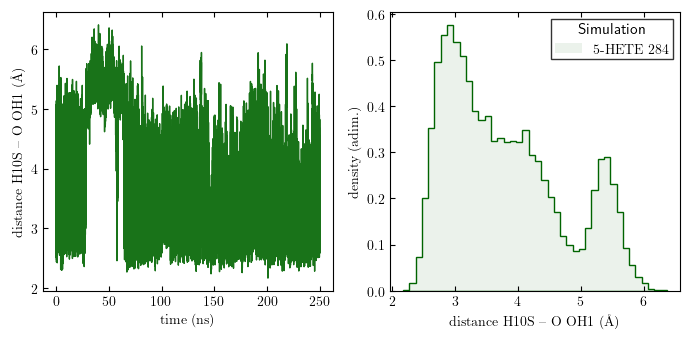

hLOX15

METRIC: 	distance H10R -- O OH1

replica 	R1
avg     	4.885
std     	0.442
max     	6.597
min     	2.560
1
algo 0 histogram explode
[4.9253496  5.33103511 4.36286482 ... 5.24268344 4.72829663 4.64259285]


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_82117/3452737144.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)


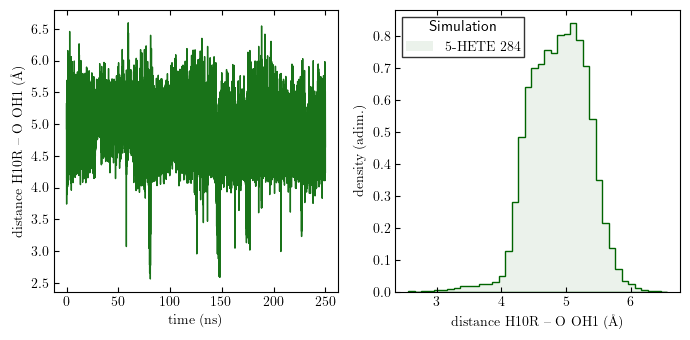

hLOX15

METRIC: 	distance C10 -- O OH1

replica 	R1
avg     	4.004
std     	0.480
max     	5.793
min     	2.947
1
algo 0 histogram explode
[3.87543408 4.33704823 3.41127671 ... 4.21745595 3.7886584  3.67274503]


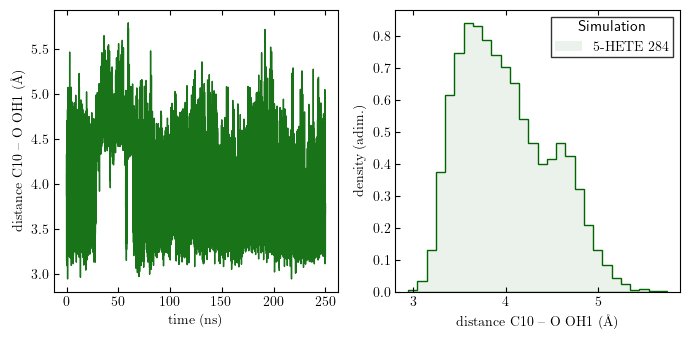

hLOX15

METRIC: 	distance H13S -- O OH1

replica 	R1
avg     	5.462
std     	0.637
max     	6.904
min     	2.293
1
algo 0 histogram explode
[5.43072944 5.44135657 6.00721919 ... 5.80862904 5.79617433 5.6642793 ]


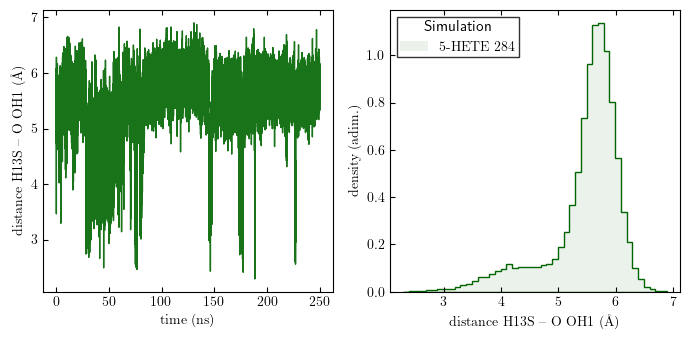

hLOX15

METRIC: 	distance H13R -- O OH1

replica 	R1
avg     	6.162
std     	1.014
max     	7.838
min     	2.264
1
algo 0 histogram explode
[6.31620653 6.41445337 7.03615558 ... 6.13325158 6.5034695  6.43975345]


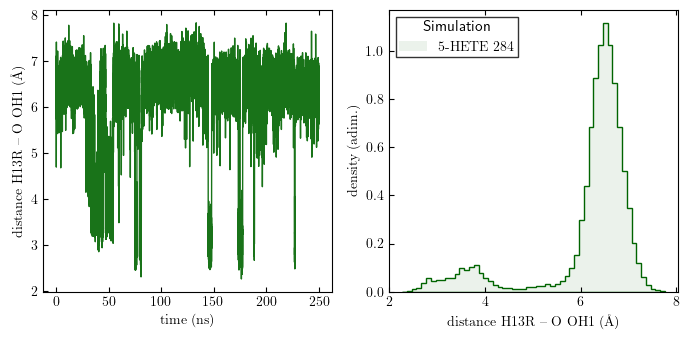

hLOX15

METRIC: 	distance C13 -- O OH1

replica 	R1
avg     	5.443
std     	0.518
max     	6.836
min     	2.920
1
algo 0 histogram explode
[5.31322433 5.4440911  6.03396085 ... 5.50929867 5.53570572 5.50437725]


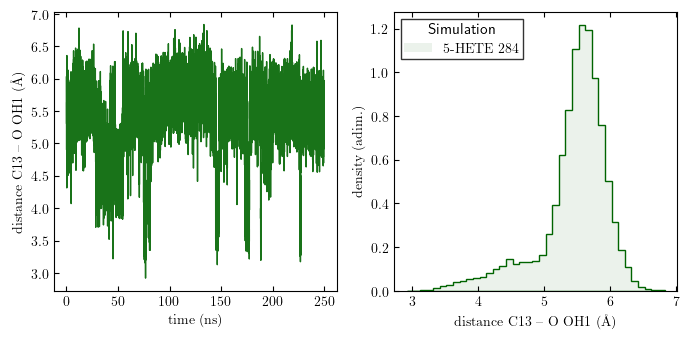

In [7]:
print(f"\nprotein \t{protein_ID}\n")
for label in distance_H_set:

    replicate_data_ALL = []

    for variant, variant_data in emda.measures[label].result.items():

        print(variant)        

        print(f'\n\033[1mMETRIC: \t{label}\n')
        replicate_data = list(variant_data.values())

        for replica, values in variant_data.items():
            if values:  
                # if values are present
                if label == 'distance H10S -- O OH1':
                    distance_H10S_value = values
                if label == 'distance H13S -- O OH1':
                    distance_H13S_value = values

                print(f"\033[0mreplica \t{replica}")
                print(f"avg     \t{average(values):.3f}")
                print(f"std     \t{std(values):.3f}")
                print(f"max     \t{max(values):.3f}")
                print(f"min     \t{min(values):.3f}")

            else:
                print(f"! replica {replica} has no values !")
                raise ValueError('Some replicas dont have any values! Abort.')
                           
        # plot wrt time
        # display all available replicas 
        metric_name = f'{label} (Å)'
        #plot_replicates_time(replicate_data, save_name=f'{label}_plot.png', metric_name=metric_name, convergence_line_last=100)
        #plot_replicates_histogram(replicate_data, save_name=f'{label}_hist.png', metric_name=metric_name, display_mean=True)

        
        plot_replicates_both(replicate_data, save_name=f'{label}_both.png', metric_name=metric_name, display_mean=False, skip=None, replica_names=replica_names, convergence_line_last=None)

In [8]:
def plot_two_metrics_hist(replicate_data, save_name, metric_name=r'', convergence_line_last=5, x_time=True, bin_size=0.1, display_mean=True, skip=None, replica_names=[], legend='', xlims=[]):

    replicate_data = np.array(replicate_data)

    # all have the same length, traj length
    frames = np.arange(1, len(replicate_data[0])+1, 1)
    
    if x_time:
        # each frame corresponds to 10 ps
        # 10 ns, produces 1000 frames, i.e. 0.01 ns / frame
        times = frames * 0.01 

    bins = np.arange(np.min(replicate_data), np.max(replicate_data), bin_size)

    # generate time figure
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(3.5, 3.5))
    _axes = [axes]

    # color lists
    colors = ['darkgreen', 'deeppink', 'mediumblue', 'orange']
    colors = ['mediumblue', 'deeppink']

    # histogram
    _axes[0].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
    _axes[0].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

    # for each replicate
    for j in range(len(replicate_data)):
        # filling
        _axes[0].hist(replicate_data[j], bins=bins, density=True, edgecolor=colors[j], color='w', histtype='stepfilled', alpha=1)

    # for each replicate
    for j in range(len(replicate_data)):

        # contour
        if len(replica_names) != 0:
            if j==0:
                _axes[0].hist(replicate_data[j], bins=bins, density=True, color=colors[j], alpha=.1, label=r'$\textnormal{'+f'{replica_names[j]}'+r' }$')  
            else: 
                _axes[0].hist(replicate_data[j], bins=bins, density=True, color=colors[j], alpha=.02, label=r'$\textnormal{'+f'{replica_names[j]}'+r' }$')  
        else:
            _axes[0].hist(replicate_data[j], bins=bins, density=True, color=colors[j], alpha=.6, label=r'$\textnormal{replicate '+f'{j+1}'+r' }$')    
        if display_mean:
            if len(replica_names) != 0:
                _axes[0].axvline(x=np.average(replicate_data[j]), color=colors[j], alpha=0.8, ls='dotted', label=r'$\textnormal{average r'+f'{replica_names[j]}'+'}$') 
            else: 
                _axes[0].axvline(x=np.average(replicate_data[j]), color=colors[j], alpha=0.8, ls='dotted', label=r'$\textnormal{average r'+f'{j+1}'+'}$') 

    # labels
    _axes[0].set(xlabel=r'$\textnormal{'+f'{metric_name}'+'}$', ylabel=r'$\textnormal{density (adim.)}$')
    _axes[0].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'{legend}'+'}$', title_fontsize=11)
    if len(xlims) != 0:
        _axes[0].set_xlim(left=xlims[0], right=xlims[1])

    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, save_name), dpi=400)
    plt.show(fig)

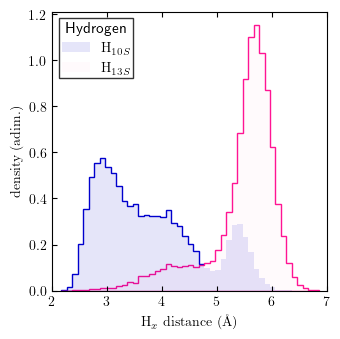

In [9]:
plot_two_metrics_hist(
    [distance_H10S_value, distance_H13S_value], 
    save_name='H10_H13_hist.png', 
    metric_name=r'H$_x$ distance (Å)', x_time=True, bin_size=0.1, skip=None, replica_names=[r'\textnormal{H$_{10S}$}', r'\textnormal{H$_{13S}$}'], display_mean=False, legend='Hydrogen', xlims=[2,7])

### __GLU175 - ARG402__


protein 	hLOX15


METRIC: 	distance GLU175 OE1 -- ARG402 NH1

replica 	R1
avg     	3.981
std     	1.377
max     	11.000
min     	2.501
1
algo 0 histogram explode
[4.86068818 4.45499306 4.43103976 ... 2.87112322 2.77697617 2.70481585]


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_82117/3452737144.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)


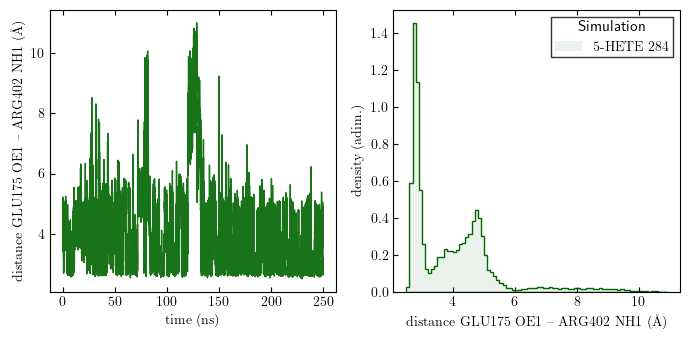


METRIC: 	distance GLU175 OE1 -- ARG402 NH2

replica 	R1
avg     	4.211
std     	1.407
max     	10.764
min     	2.561
1
algo 0 histogram explode
[5.65839868 5.48868467 5.63203909 ... 2.99370529 3.24847786 3.3970327 ]


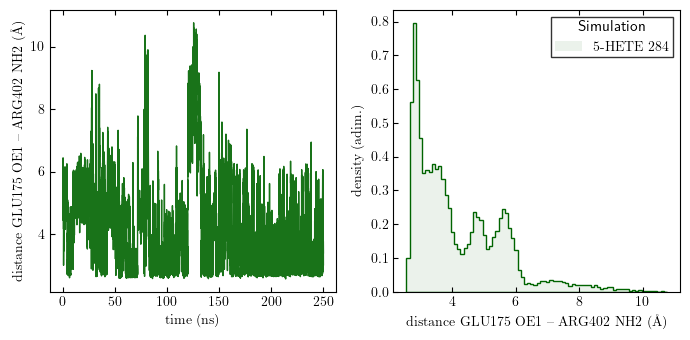

In [10]:
print(f"\nprotein \t{protein_ID}\n")
for label in distance_GLU_ARG:

    for variant, variant_data in emda.measures[label].result.items():
        

        print(f'\n\033[1mMETRIC: \t{label}\n')
        replicate_data = list(variant_data.values())

        for replica, values in variant_data.items():
            if values:  
                # if values are present

                print(f"\033[0mreplica \t{replica}")
                print(f"avg     \t{average(values):.3f}")
                print(f"std     \t{std(values):.3f}")
                print(f"max     \t{max(values):.3f}")
                print(f"min     \t{min(values):.3f}")

            else:
                print(f"! replica {replica} has no values !")
                raise ValueError('Some replicas dont have any values! Abort.')
               
        
        # plot wrt time
        # display all available replicas 
        metric_name = f'{label} (Å)'
        #plot_replicates_time(replicate_data, save_name=f'{label}_plot.png', metric_name=metric_name, convergence_line_last=100)
        #plot_replicates_histogram(replicate_data, save_name=f'{label}_hist.png', metric_name=metric_name, display_mean=True)
        plot_replicates_both(replicate_data, save_name=f'{label}_both.png', metric_name=metric_name, display_mean=False, skip=None, replica_names=replica_names, convergence_line_last=None)

### __carboxylate - ARG402__


protein 	hLOX15


METRIC: 	distance COO O1 -- ARG402 NE

replica 	R1
avg     	8.517
std     	1.168
max     	12.307
min     	5.119
1
algo 0 histogram explode
[6.86697504 7.64310576 7.11503419 ... 8.66104913 7.97097565 8.35318221]


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_82117/3452737144.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)


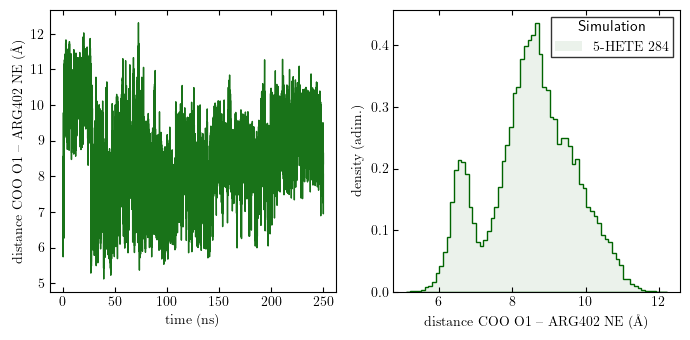


METRIC: 	distance COO O1 -- ARG402 NH1

replica 	R1
avg     	7.210
std     	1.202
max     	10.920
min     	3.704
1
algo 0 histogram explode
[5.76400346 6.44464011 6.50089831 ... 7.25592694 6.71823273 7.55583844]


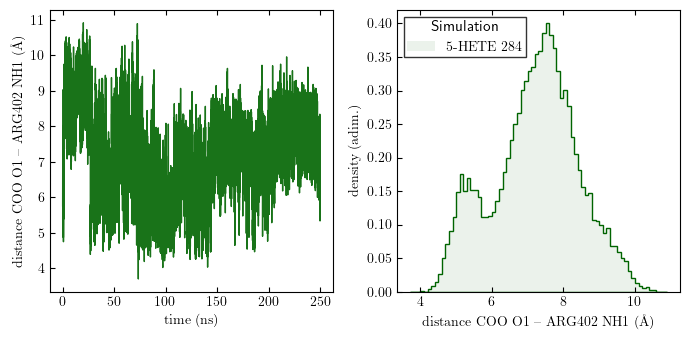


METRIC: 	distance COO O1 -- ARG402 NH2

replica 	R1
avg     	9.288
std     	1.194
max     	13.091
min     	5.948
1
algo 0 histogram explode
[7.89257628 8.65736725 8.58914692 ... 9.1857553  8.87840507 9.44570886]


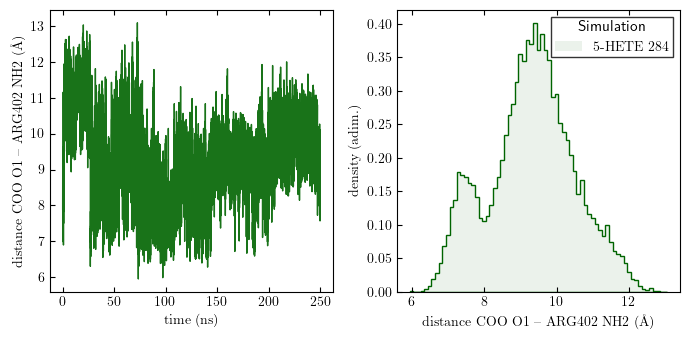


METRIC: 	distance COO O2 -- ARG402 NE

replica 	R1
avg     	8.523
std     	1.052
max     	12.262
min     	5.213
1
algo 0 histogram explode
[8.84296485 9.55989073 9.03284881 ... 9.27652861 8.82692462 8.82460894]


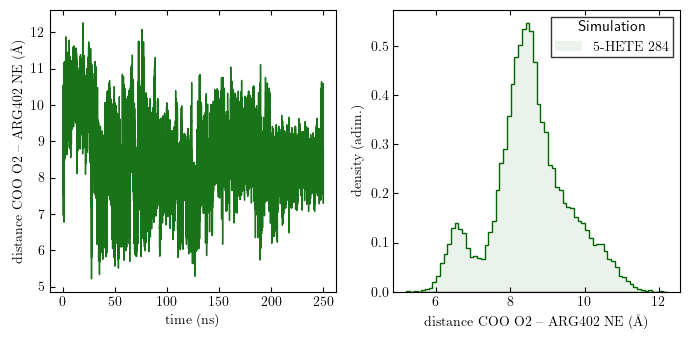


METRIC: 	distance COO O2 -- ARG402 NH1

replica 	R1
avg     	7.211
std     	1.085
max     	11.214
min     	3.905
1
algo 0 histogram explode
[7.57486498 8.07305296 8.16149719 ... 7.76358451 7.38270626 7.81702691]


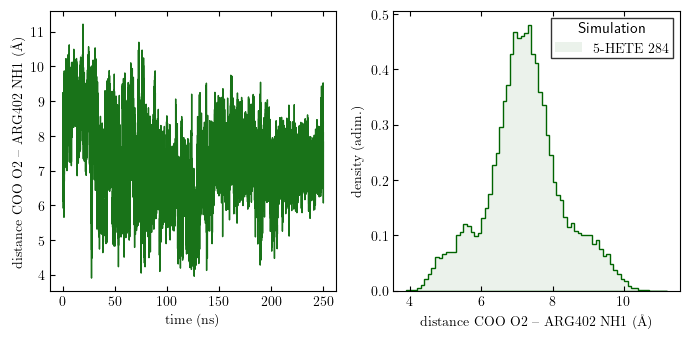


METRIC: 	distance COO O2 -- ARG402 NH2

replica 	R1
avg     	9.294
std     	1.087
max     	13.243
min     	6.032
1
algo 0 histogram explode
[ 9.66152133 10.33155892 10.31633649 ...  9.8900562   9.66917645
  9.89414901]


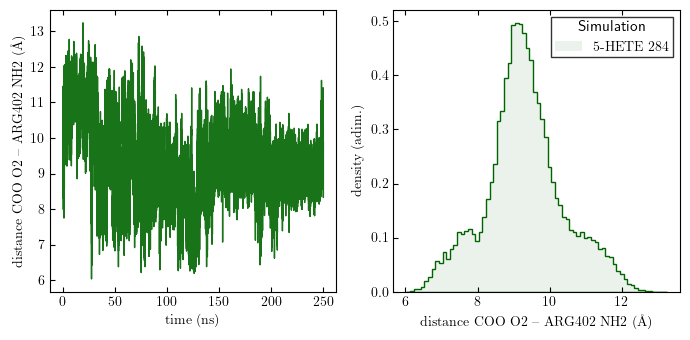

In [11]:
print(f"\nprotein \t{protein_ID}\n")
for label in distance_COO_set:

    for variant, variant_data in emda.measures[label].result.items():
        

        print(f'\n\033[1mMETRIC: \t{label}\n')
        replicate_data = list(variant_data.values())

        for replica, values in variant_data.items():
            if values:  
                # if values are present

                print(f"\033[0mreplica \t{replica}")
                print(f"avg     \t{average(values):.3f}")
                print(f"std     \t{std(values):.3f}")
                print(f"max     \t{max(values):.3f}")
                print(f"min     \t{min(values):.3f}")

            else:
                print(f"! replica {replica} has no values !")
                raise ValueError('Some replicas dont have any values! Abort.')
               
        
        # plot wrt time
        # display all available replicas 
        metric_name = f'{label} (Å)'
        #plot_replicates_time(replicate_data, save_name=f'{label}_plot.png', metric_name=metric_name, convergence_line_last=100)
        #plot_replicates_histogram(replicate_data, save_name=f'{label}_hist.png', metric_name=metric_name, display_mean=True)
        plot_replicates_both(replicate_data, save_name=f'{label}_both.png', metric_name=metric_name, display_mean=False, skip=None, replica_names=replica_names, convergence_line_last=None)

### __methyl - ILE417__


protein 	hLOX15


METRIC: 	distance Methyl -- ILE417 CD1

replica 	R1
avg     	5.203
std     	1.316
max     	10.157
min     	3.155
1
algo 0 histogram explode
[4.49185371 4.64755898 4.2420493  ... 4.61336074 5.12616512 3.86688193]


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_82117/3452737144.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)


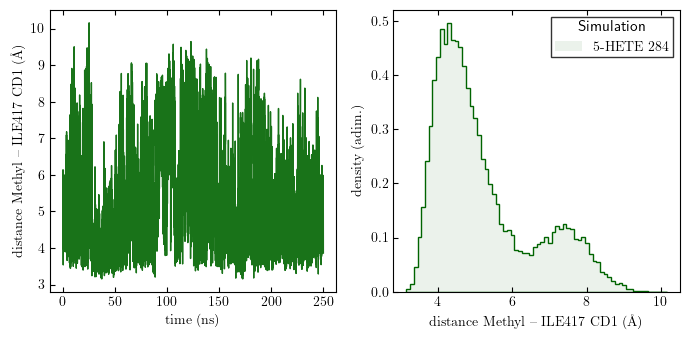

In [12]:
print(f"\nprotein \t{protein_ID}\n")
for label in distance_Met_set:

    for variant, variant_data in emda.measures[label].result.items():
        

        print(f'\n\033[1mMETRIC: \t{label}\n')
        replicate_data = list(variant_data.values())

        for replica, values in variant_data.items():
            if values:  
                # if values are present

                print(f"\033[0mreplica \t{replica}")
                print(f"avg     \t{average(values):.3f}")
                print(f"std     \t{std(values):.3f}")
                print(f"max     \t{max(values):.3f}")
                print(f"min     \t{min(values):.3f}")

            else:
                print(f"! replica {replica} has no values !")
                raise ValueError('Some replicas dont have any values! Abort.')
               
        
        # plot wrt time
        # display all available replicas 
        metric_name = f'{label} (Å)'
        #plot_replicates_time(replicate_data, save_name=f'{label}_plot.png', metric_name=metric_name, convergence_line_last=100)
        #plot_replicates_histogram(replicate_data, save_name=f'{label}_hist.png', metric_name=metric_name, display_mean=True)
        plot_replicates_both(replicate_data, save_name=f'{label}_both.png', metric_name=metric_name, display_mean=False, skip=None, replica_names=replica_names, convergence_line_last=None)

## __Dihedrals (planarity of reactive site)__

### __local C10 planarity__
### __local C13 planarity__


protein 	hLOX15


METRIC: 	dihedral C12--C11--C10--C9 (C10 planarity)

replica 	R1
avg     	161.937
std     	51.438
max     	350.764
min     	0.273
1
algo 0 histogram explode
[189.42813759 221.90645789 149.70114907 ... 155.94128296 136.58440938
 137.74210901]


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_82117/3452737144.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)


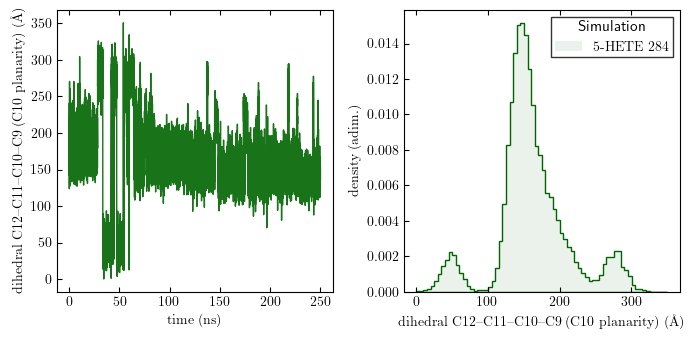


METRIC: 	dihedral C11--C12--C13--C14 (C13 planarity)

replica 	R1
avg     	133.027
std     	29.476
max     	358.765
min     	36.391
1
algo 0 histogram explode
[133.83505764 129.5185389   99.93687163 ... 128.20455573 117.56128647
 117.64655771]


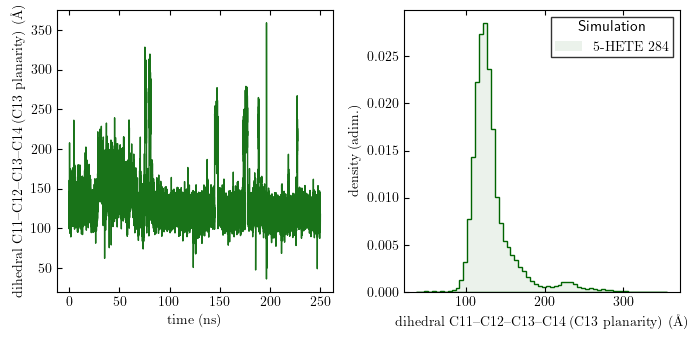

In [13]:
print(f"\nprotein \t{protein_ID}\n")
for label in dihedral_set:

    for variant, variant_data in emda.measures[label].result.items():
        

        print(f'\n\033[1mMETRIC: \t{label}\n')
        replicate_data = list(variant_data.values())

        for replica, values in variant_data.items():
            if values:  
                # if values are present
                if label == 'dihedral C12--C11--C10--C9 (C10 planarity)':
                    dih_C10_value = values
                if label == 'dihedral C11--C12--C13--C14 (C13 planarity)':
                    dih_C13_value = values

                print(f"\033[0mreplica \t{replica}")
                print(f"avg     \t{average(values):.3f}")
                print(f"std     \t{std(values):.3f}")
                print(f"max     \t{max(values):.3f}")
                print(f"min     \t{min(values):.3f}")

            else:
                print(f"! replica {replica} has no values !")
                raise ValueError('Some replicas dont have any values! Abort.')
               
        
        # plot wrt time
        # display all available replicas 
        metric_name = f'{label} (Å)'
        #plot_replicates_time(replicate_data, save_name=f'{label}_plot.png', metric_name=metric_name, convergence_line_last=100)
        #plot_replicates_histogram(replicate_data, save_name=f'{label}_hist.png', metric_name=metric_name, display_mean=True)
        plot_replicates_both(replicate_data, save_name=f'{label}_both.png', metric_name=metric_name, display_mean=False, skip=None, replica_names=replica_names, convergence_line_last=None, bin_size=5)

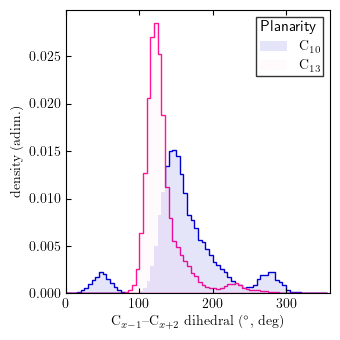

In [14]:
plot_two_metrics_hist(
    [dih_C10_value, dih_C13_value], 
    save_name='C10_C13_DIH_hist.png', 
    metric_name=r'C$_{x-1}$--C$_{x+2}$ dihedral ($^\circ$, deg)', x_time=True, bin_size=5, skip=None, replica_names=[r'\textnormal{C$_{10}$}', r'\textnormal{C$_{13}$}'], display_mean=False, legend='Planarity', xlims=[0, 360])

## __RMSD analysis__

### __`\alpha`-C RMSD__
### __Backbone RMSD__


protein 	hLOX15


METRIC: 	5-HETE RMSD

replica 	R1
avg     	1.654
std     	0.286
max     	2.690
min     	0.000
1
algo 0 histogram explode
[0.00000009 0.59928856 0.89939925 ... 1.35866751 1.45034004 1.34622781]


/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_82117/3452737144.py:166: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _axes[1].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Simulations'+'}$', title_fontsize=11)


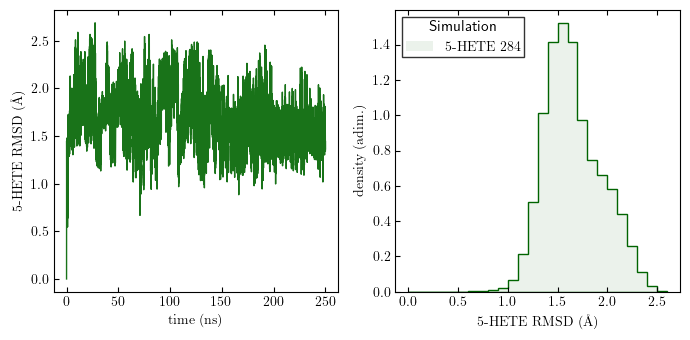


METRIC: 	backbone RMSD

replica 	R1
avg     	1.497
std     	0.259
max     	2.253
min     	0.000
1
algo 0 histogram explode
[0.00000094 0.58732147 0.63317815 ... 1.57850519 1.68549382 1.64476541]


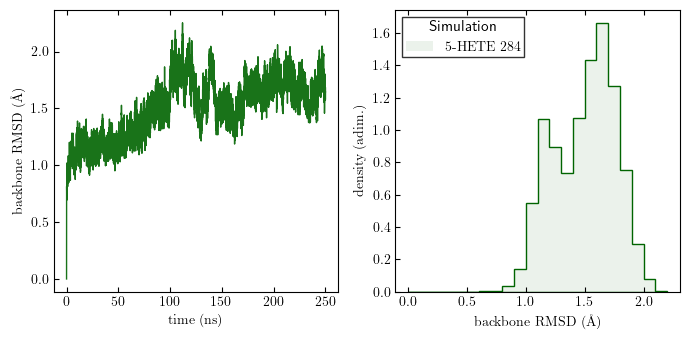

In [15]:
print(f"\nprotein \t{protein_ID}\n")
for label in rmsd_set:

    for variant, variant_data in emda.measures[label].result.items():
        

        print(f'\n\033[1mMETRIC: \t{label}\n')
        replicate_data = list(variant_data.values())

        for replica, values in variant_data.items():
            if values:  
                # if values are present

                print(f"\033[0mreplica \t{replica}")
                print(f"avg     \t{average(values):.3f}")
                print(f"std     \t{std(values):.3f}")
                print(f"max     \t{max(values):.3f}")
                print(f"min     \t{min(values):.3f}")

            else:
                print(f"! replica {replica} has no values !")
                raise ValueError('Some replicas dont have any values! Abort.')
               
        
        # plot wrt time
        # display all available replicas 
        metric_name = f'{label} (Å)'
        #plot_replicates_time(replicate_data, save_name=f'{label}_plot.png', metric_name=metric_name, convergence_line_last=100)
        #plot_replicates_histogram(replicate_data, save_name=f'{label}_hist.png', metric_name=metric_name, display_mean=True)
        plot_replicates_both(replicate_data, save_name=f'{label}_both.png', metric_name=metric_name, display_mean=False, skip=None, replica_names=replica_names, convergence_line_last=None)

### __TODO: Specific sidechain RMSD analysis__

In [16]:
# if needed

## __Contacts Analysis__

### __Ligand COO-__

### __5-HETE OH hydroxyl group__

### __5-HpETE OOH peroxo group__

In [17]:
contacts_emda = EMDA()

# for each complete tajectory
for t in range(len(traj_1)):

    contacts_emda.load_variant(
        parameters=top,
        trajectory=traj_1[t],
        variant_name=f'partial_prod_{t+1}'
    )



# contacts

if lig_ID == lig_ID_list[0]:

    contacts_emda.select('COO', [10554, 10555, 10556], sel_type='at_num')
    contacts_emda.add_contacts('COO contacts', 'COO', sel_env=4, include_WAT=True)
    contacts_set = ['contacts COO']

elif lig_ID == lig_ID_list[1]:

    contacts_emda.select('COO', [10604, 10605, 10606], sel_type='at_num')
    contacts_emda.select('OOH', [10607, 10608, 10590], sel_type='at_num')
    contacts_emda.add_contacts('OOH contacts', 'OOH', sel_env=4, include_WAT=True)
    contacts_emda.add_contacts('COO contacts', 'COO', sel_env=4, include_WAT=True)
    contacts_set = ['COO contacts', 'OOH contacts']

elif lig_ID == lig_ID_list[2]:

    contacts_emda.select('COO', [10603, 10604, 10605], sel_type='at_num')
    contacts_emda.select('OH', [10606, 10607], sel_type='at_num')
    contacts_emda.add_contacts('OH contacts', 'OH', sel_env=4, include_WAT=True)
    contacts_emda.add_contacts('COO contacts', 'COO', sel_env=4, include_WAT=True)
    contacts_set = ['COO contacts', 'OH contacts']

if load_results:
    contacts_emda.load(os.path.join(md_analysis_base_dir, parent_dir, f'{protein_ID}_{lig_ID}_analysis_contacts.pkl'))
else:
    contacts_emda.run()
    contacts_emda.save(os.path.join(md_analysis_base_dir, parent_dir, f'{protein_ID}_{lig_ID}_analysis_contacts'))

print(contacts_emda.universe)

/Users/sergiortizropero/miniconda3/envs/md_traj/lib/python3.12/site-packages/MDAnalysis/topology/TOPParser.py:342: UserWarning: Unknown ATOMIC_NUMBER value found for some atoms, these have been given an empty element record. If needed these can be guessed using universe.guess_TopologyAttrs(to_guess=['elements']).
  warnings.warn(msg)


partial_prod_1 variant has been loaded!
partial_prod_2 variant has been loaded!
partial_prod_3 variant has been loaded!
partial_prod_4 variant has been loaded!
partial_prod_5 variant has been loaded!
partial_prod_6 variant has been loaded!
partial_prod_7 variant has been loaded!
partial_prod_8 variant has been loaded!
partial_prod_9 variant has been loaded!
partial_prod_10 variant has been loaded!
partial_prod_11 variant has been loaded!
partial_prod_12 variant has been loaded!
partial_prod_13 variant has been loaded!
partial_prod_14 variant has been loaded!
partial_prod_15 variant has been loaded!
partial_prod_16 variant has been loaded!
partial_prod_17 variant has been loaded!
partial_prod_18 variant has been loaded!
partial_prod_19 variant has been loaded!
partial_prod_20 variant has been loaded!
partial_prod_21 variant has been loaded!
partial_prod_22 variant has been loaded!
partial_prod_23 variant has been loaded!
partial_prod_24 variant has been loaded!
partial_prod_25 variant h

In [18]:
# contacts data (global info)
print(f'total number of frames:\t{total_time_simulated * 100}')


contact_set_freq = [f'{x}_freq' for x in contacts_set]
contact_set_freq_percent = [f'{x}_freq_percent' for x in contacts_set]

print(contact_set_freq_percent)
contact_set_amount = [f'{x}_freq_amount' for x in contacts_set]
for contact in contacts_set:
    emda.analyse_contacts_frequency(f'{contact}_freq', contact)
    emda.analyse_contacts_frequency(f'{contact}_freq_percent', contact, percentage=True)
    emda.analyse_contacts_amount(f'{contact}_amount', contact)

emda.measures

total number of frames:	25000
['COO contacts_freq_percent', 'OH contacts_freq_percent']


{'distance H10S -- O OH1': Measure dataclass with:
 	Name:   distance H10S -- O OH1
 	Type:   distance
 	Sel:    ['OH1', 'H10S']
 	Status: 
 		hLOX15, R1: Calculated,
 'distance H10R -- O OH1': Measure dataclass with:
 	Name:   distance H10R -- O OH1
 	Type:   distance
 	Sel:    ['OH1', 'H10R']
 	Status: 
 		hLOX15, R1: Calculated,
 'distance C10 -- O OH1': Measure dataclass with:
 	Name:   distance C10 -- O OH1
 	Type:   distance
 	Sel:    ['OH1', 'C10']
 	Status: 
 		hLOX15, R1: Calculated,
 'distance H13S -- O OH1': Measure dataclass with:
 	Name:   distance H13S -- O OH1
 	Type:   distance
 	Sel:    ['OH1', 'H13S']
 	Status: 
 		hLOX15, R1: Calculated,
 'distance H13R -- O OH1': Measure dataclass with:
 	Name:   distance H13R -- O OH1
 	Type:   distance
 	Sel:    ['OH1', 'H13R']
 	Status: 
 		hLOX15, R1: Calculated,
 'distance C13 -- O OH1': Measure dataclass with:
 	Name:   distance C13 -- O OH1
 	Type:   distance
 	Sel:    ['OH1', 'C13']
 	Status: 
 		hLOX15, R1: Calculated,
 'di

In [19]:
def plot_contacts_histogram(dict_list, residue_names):
    '''
    plot bar plot for each label, with replicas of the contacts of a given group of atoms 
    '''

    # for each contact
    for i  in range(len(dict_list)):
        
        # define the figure (subfigures = num of replicas)

        #print(len(dict_list))
        fig, axes = plt.subplots(ncols=len(dict_list[i]), nrows=1, figsize=(4.5*len(dict_list[i]), 4))
        if len(dict_list[i]) == 1:
            _axes = [axes]
        else:
            _axes = axes

        # for each replica
        for j in range(len(dict_list[i])):
            data_dict = dict_list[i][j]
            filtered_dict = data_dict.copy()

            for key in data_dict.keys():
                if key not in residue_names[i]:
                    #print(f'{key} not in {residue_names[i]}')
                    filtered_dict.pop(key, None)

            for res in residue_names[i]:
                if res not in data_dict.keys():
                    filtered_dict[res] = 0.0

            residue_list = [r'$\textnormal{'+f'{x}'+r'}$' for x in list(filtered_dict.keys())]
            value_list =  list(filtered_dict.values())
            #print(residue_list)
            #print(value_list)


            _axes[j].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
            _axes[j].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")
            _axes[j].tick_params(axis='x', labelrotation=60) 
            
            _axes[j].bar(residue_list, value_list, width=4.5/(len(residue_names[i])+ 0.1*len(residue_names[i])), facecolor='darkgreen', alpha=0.1)
            _axes[j].bar(residue_list, value_list, width=4.5/(len(residue_names[i])+ 0.1*len(residue_names[i])), linewidth=1, edgecolor='darkgreen', fill=False)

            # labels
            if j==0:
                _axes[j].set(ylabel=r'$\textnormal{'+f'contact frequency (percent)'+'}$')
            _axes[j].set(xlabel=r'$\textnormal{residue ID}$')

            #print(data_dict)

    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, f'contacts_hist {label}'), dpi=400)
    plt.show(fig)




protein 	hLOX15
global contacts analysis

METRIC: 	COO contacts_freq_percent

replica 	R1
  LEU178	74.032
  PHE174	40.636
  GLN595	40.308
  GLY406	34.896
  LEU182	33.364
  ILE413	23.068
  LEU407	22.68
  ARG402	8.904
  ALA179	5.108
  ILE592	2.704
  GLU175	2.428
  VAL176	0.844
  THR405	0.244
  SER177	0.172
  LEU596	0.076
  ALA403	0.052
  GLN416	0.012
{'LEU178': 74.032, 'PHE174': 40.636, 'GLN595': 40.308, 'GLY406': 34.896, 'LEU182': 33.364, 'ILE413': 23.068, 'LEU407': 22.68, 'ARG402': 8.904, 'ALA179': 5.108, 'ILE592': 2.704, 'GLU175': 2.428, 'VAL176': 0.844, 'THR405': 0.244, 'SER177': 0.172, 'LEU596': 0.076, 'ALA403': 0.052, 'GLN416': 0.012}

METRIC: 	OH contacts_freq_percent

replica 	R1
  ARG402	95.408
  LEU407	84.84
  GLY406	83.912
  ALA403	80.392
  PHE174	33.676
  ILE399	14.952
  ILE413	6.392
  THR405	2.976
  VAL408	2.54
  LEU178	1.356
  ASN400	1.336
  ILE592	0.484
  LEU596	0.128
  GLU398	0.032
  PHE166	0.004
{'ARG402': 95.408, 'LEU407': 84.84, 'GLY406': 83.912, 'ALA403': 80.392, 'PH

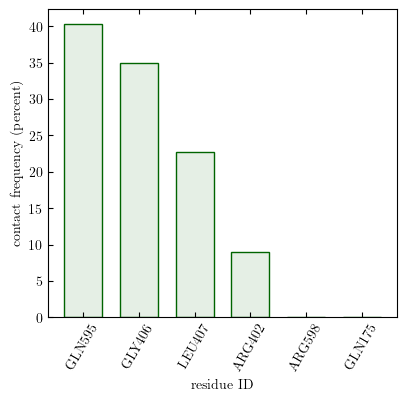

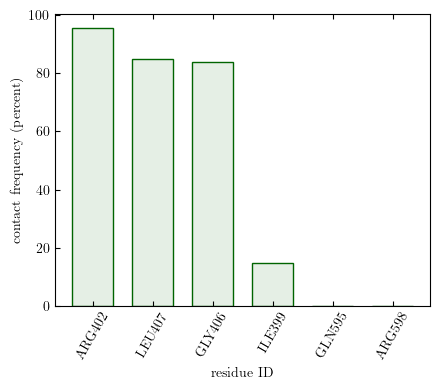

In [20]:
# DISPLAY GLOBAL INFO
display_water = False


print(f"\nprotein \t{protein_ID}")
print('global contacts analysis')

# label, replica, per cada replica un dictionary
dict_list = []


for label in contact_set_freq_percent:

    label_dict_list = []

    for variant, variant_data in emda.analyses[label].result.items():
        
        print(f'\n\033[1mMETRIC: \t{label}\n\033[0m')
        replicate_data = list(variant_data.values())
        
        for replica, values in variant_data.items():
        
            if values:  
                print(f"\033[0mreplica \t{replica}")
                sorted_dict = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
                new_dict = sorted_dict.copy()

                for residue, frequency in sorted_dict.items():
                    
                    if display_water:
                        print(f'  {residue}\t{frequency}')
                    else: 
                        if 'WAT' not in residue:
                            print(f'  {residue}\t{frequency}')
                        else: 
                            new_dict.pop(residue, None)
            else:
                print(f"! replica {replica} has no values !")
                raise ValueError('Some replicas dont have any values! Abort.')

            print(new_dict)
            label_dict_list.append(new_dict)
        
        dict_list.append(label_dict_list)
                   
residue_names = [['ARG402', 'GLN595', 'LEU407', 'GLY406', 'ARG598', 'GLN175'], ['ARG402', 'LEU407', 'GLY406', 'GLN595', 'ARG598', 'ILE399']]
plot_contacts_histogram(dict_list, residue_names)

In [21]:
# plotting contacts for every file 


def plot_contacts_evolution(contact_dict_list, residue_names, traj_list):
    '''
    PLOT SELECTED CONTACTS (A PRIORI, RESXXX) EVOLUTION. ONE REPLICA SUPPORTED!

    contact_dict_list is a list of contact dictionaries, with the frequency of contact for each mini-traj file. 


    dictionary containing

    '''

    # small traj files, for each of these plot the contacts
    x = np.arange(1, len(traj_list)+1) * 10 

    fig, axes = plt.subplots(ncols=len(contact_dict_list), nrows=1, figsize=(4*len(contact_dict_list), 4))
    if len(contact_dict_list) == 1:
        _axes = [axes]
    else:
        _axes = axes


    # color lists
    colors = ['darkviolet', 'crimson', 'deeppink', 'darkgreen', 'mediumseagreen', 'royalblue', 'darkblue']

    # marker list
    marker = ['o', '^', 'd', 's', 'h',  'x', 'o', 'o', 'o']

    k=0
    for key, value in contact_dict_list.items():
        
        data = []

        for res_name in residue_names[k]:
            temp = [res_name]
            for i in range(len(value)):
                try:
                    temp.append(value[i][res_name])
                except: 
                    temp.append(0.0)


            data.append(temp)
        #print('data', data)

        _axes[k].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
        _axes[k].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")

        for i in range(len(data)):
            _label = data[i][0]
            #print('printing label', _label)
            _values = data[i][1:]   
            #print('printing values', _values)
            
            _axes[k].plot(x, _values, label=r'$\textnormal{'+f'{_label}'+'}$', marker=marker[i], color=colors[i], alpha=0.7)
            
        # labels
        _axes[k].set(xlabel=r'$\textnormal{time (ns)}$', ylabel=r'$\textnormal{'+f'frequency (percent)'+'}$')
        _axes[k].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'{key}'+'}$', title_fontsize=11)

        k+=1
    
    plt.tight_layout()
    plt.savefig(os.path.join(md_analysis_base_dir, parent_dir, 'contacts.png'), dpi=400)
    plt.show(fig)

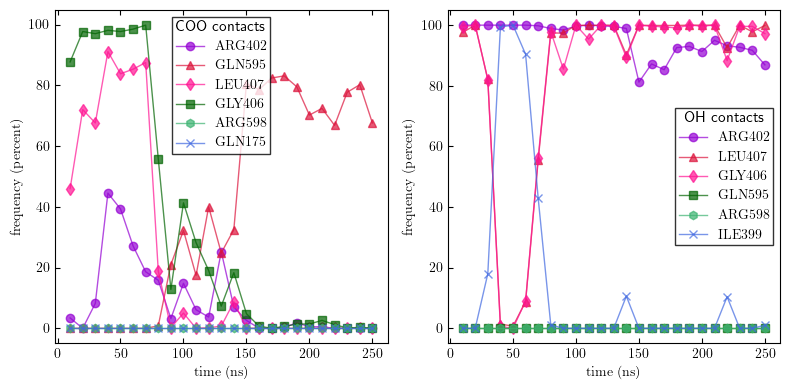

In [22]:
# ultra shitty code
# contacts evolution

algo_dict = {}
for label in contacts_set:

    # shitty code    
    dict_list = []
    contacts_emda.analyse_contacts_frequency(f'{label}_freq_percent', label, percentage=True)

    for variant, variant_data in contacts_emda.analyses[f'{label}_freq_percent'].result.items():
        
        #print(f'\n\033[1mMETRIC: \t{label}\n\033[0m')
        replicate_data = list(variant_data.values())
        

        for replica, values in variant_data.items():
        
            if values:  
                #print(f"\033[0mreplica \t{replica}")
                sorted_dict = dict(sorted(values.items(), key=lambda item: item[1], reverse=True))
                new_dict = sorted_dict.copy()

                for residue, frequency in sorted_dict.items():
                    
                    if display_water:
                        #print(f'  {residue}\t{frequency}')
                        pass
                    else: 
                        if 'WAT' not in residue:
                            #print(f'  {residue}\t{frequency}')
                            pass
                        else: 
                            new_dict.pop(residue, None)

                dict_list.append(new_dict)

    algo_dict[label] = dict_list
            


plot_contacts_evolution(algo_dict, residue_names, traj_list=traj_1)

# plot contacts OH and OOH with 407, 406, ILE399, 

## __Distance + dihedral PDF__

### __Distance H13 proS to OH & planarity (dihedral)__

In [23]:
emda.analyse_probability_density('pdf H13S', ['distance H13S -- O OH1', 'dihedral C11--C12--C13--C14 (C13 planarity)'], num_of_points=100, get_basins=True)
emda.analyses['pdf H13S']
emda.plot_probability_densities(
    'pdf H13S', 
    width_per_replica=4.5, 
    plot_measures=False,  
    plot_minima=False, 
    height_per_variant=4, 
    show_contour_lines=False, 
    levels_fill=100, 
    color_map='BuPu_r', 
    max_level=10, 
    set_names_in_axis=False, 
    xname='distance H13S -- O OH1', 
    yname='dihedral C11--C12--C13--C14 (C13 planarity)', 
    out_name=os.path.join(md_analysis_base_dir, parent_dir, 'pdf_H13S.png'), 
    xlims=[2,7],
    ylims=[0, 360],
    md_label=replica_names[0],
)

generating pdf... one replica, one variant
test, here we are!


/Users/sergiortizropero/miniconda3/envs/md_traj/lib/python3.12/site-packages/EMDA/EMDA/plotters.py:682: UserWarning: The following kwargs were not used by contour: 'label'
  cntr = axs.tricontourf(


### __Distance H13 proR to OH & planarity (dihedral)__

In [24]:
emda.analyse_probability_density('pdf H13R', ['distance H13R -- O OH1', 'dihedral C11--C12--C13--C14 (C13 planarity)'], num_of_points=100, get_basins=True)
emda.analyses['pdf H13R']
emda.plot_probability_densities(
    'pdf H13R', 
    width_per_replica=4.5, 
    plot_measures=False,  
    plot_minima=False, 
    height_per_variant=4, 
    show_contour_lines=False, 
    levels_fill=100, 
    color_map='BuPu_r', 
    max_level=10, 
    set_names_in_axis=False, 
    xname='distance H13R -- O OH1', 
    yname='dihedral C11--C12--C13--C14 (C13 planarity)', 
    out_name=os.path.join(md_analysis_base_dir, parent_dir, 'pdf_H13R.png'),
    xlims=[2,7],
    ylims=[0, 360],
    md_label=replica_names[0],
)

generating pdf... one replica, one variant
test, here we are!


/Users/sergiortizropero/miniconda3/envs/md_traj/lib/python3.12/site-packages/EMDA/EMDA/plotters.py:682: UserWarning: The following kwargs were not used by contour: 'label'
  cntr = axs.tricontourf(


### __Distance H10 proS to OH & planarity (dihedral)__

In [25]:
emda.analyse_probability_density('pdf H10S', ['distance H10S -- O OH1', 'dihedral C12--C11--C10--C9 (C10 planarity)'], num_of_points=100, get_basins=True)
emda.analyses['pdf H10S']
emda.plot_probability_densities(
    'pdf H10S', 
    width_per_replica=4.5, 
    plot_measures=False,  
    plot_minima=False, 
    height_per_variant=4, 
    show_contour_lines=False, 
    levels_fill=100, 
    color_map='BuPu_r', 
    max_level=10, 
    set_names_in_axis=False, 
    xname='distance H10S -- O OH1', 
    yname='dihedral C12--C11--C10--C9 (C10 planarity)', 
    out_name=os.path.join(md_analysis_base_dir, parent_dir, 'pdf_H10S.png'), 
    xlims=[2,7],
    ylims=[0, 360],
    md_label=replica_names[0],
)


generating pdf... one replica, one variant
test, here we are!


### __Distance H10 proR to OH & planarity (dihedral)__

In [26]:
emda.analyse_probability_density('pdf H10R', ['distance H10R -- O OH1', 'dihedral C12--C11--C10--C9 (C10 planarity)'], num_of_points=100, get_basins=True)
emda.analyses['pdf H10R']
emda.plot_probability_densities(
    'pdf H10R', 
    width_per_replica=4.5, 
    plot_measures=False,  
    plot_minima=False, 
    height_per_variant=4, 
    show_contour_lines=False, 
    levels_fill=100, 
    color_map='BuPu_r', 
    max_level=10, 
    set_names_in_axis=False, 
    xname='distance H10R -- O OH1', 
    yname='dihedral C12--C11--C10--C9 (C10 planarity)', 
    out_name=os.path.join(md_analysis_base_dir, parent_dir, 'pdf_H10R.png'),
    xlims=[2,7],
    ylims=[0, 360],
    md_label=replica_names[0],
)


generating pdf... one replica, one variant
test, here we are!


## __Single plot analysis__

# __Example plotting__

In [27]:
path = './'
import os
with open(os.path.join(path, 'algo.txt'), 'w') as f:
    f.write(f'# Precatalytic structure computation from MD trajectory\n')
    f.write(f'# Sergi Ortiz @ UAB\n')
    f.write(f'# hLOX15 AA\n')
    f.write(f'# Criterium 1: Distance  H10 < 3 A\n')
    f.write(f'# Criterium 2: Planarity C10 = 180 +- 5 deg\n')    
    f.write('\n')
    f.write('MD run\t\tCriterium 1 (%)\t\tCriterium 2 (%)\t\tFrames\t\tPrecat (%)\t\tPercent\n')